In [1]:
from numpy import *
from numpy.random import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)

# v_mins
n = 1000
v_min = linspace(0.01,750.0,n)

# Times
ndays = 1000
days = linspace(0.0,365.0-365.0/ndays,ndays)

gmin_Iso = zeros(shape=(ndays,n))
gmin_Iso_gf = zeros(shape=(ndays,n))

isub = 0
gmin_S1_gf = zeros(shape=(ndays,n))
for i in range(0,ndays):
    gmin_Iso[i,:] = gvmin_Triaxial(v_min,days[i],sig_iso)
    gmin_Iso_gf[i,:] = gvmin_Triaxial(v_min,days[i],sig_iso,GravFocus=True)
    print('day = ',i+1,'of',ndays)
    




day =  1 of 1000
day =  2 of 1000
day =  3 of 1000
day =  4 of 1000
day =  5 of 1000
day =  6 of 1000
day =  7 of 1000
day =  8 of 1000
day =  9 of 1000
day =  10 of 1000
day =  11 of 1000
day =  12 of 1000
day =  13 of 1000
day =  14 of 1000
day =  15 of 1000
day =  16 of 1000
day =  17 of 1000
day =  18 of 1000
day =  19 of 1000
day =  20 of 1000
day =  21 of 1000
day =  22 of 1000
day =  23 of 1000
day =  24 of 1000
day =  25 of 1000
day =  26 of 1000
day =  27 of 1000
day =  28 of 1000
day =  29 of 1000
day =  30 of 1000
day =  31 of 1000
day =  32 of 1000
day =  33 of 1000
day =  34 of 1000
day =  35 of 1000
day =  36 of 1000
day =  37 of 1000
day =  38 of 1000
day =  39 of 1000
day =  40 of 1000
day =  41 of 1000
day =  42 of 1000
day =  43 of 1000
day =  44 of 1000
day =  45 of 1000
day =  46 of 1000
day =  47 of 1000
day =  48 of 1000
day =  49 of 1000
day =  50 of 1000
day =  51 of 1000
day =  52 of 1000
day =  53 of 1000
day =  54 of 1000
day =  55 of 1000
day =  56 of 1000
d

day =  438 of 1000
day =  439 of 1000
day =  440 of 1000
day =  441 of 1000
day =  442 of 1000
day =  443 of 1000
day =  444 of 1000
day =  445 of 1000
day =  446 of 1000
day =  447 of 1000
day =  448 of 1000
day =  449 of 1000
day =  450 of 1000
day =  451 of 1000
day =  452 of 1000
day =  453 of 1000
day =  454 of 1000
day =  455 of 1000
day =  456 of 1000
day =  457 of 1000
day =  458 of 1000
day =  459 of 1000
day =  460 of 1000
day =  461 of 1000
day =  462 of 1000
day =  463 of 1000
day =  464 of 1000
day =  465 of 1000
day =  466 of 1000
day =  467 of 1000
day =  468 of 1000
day =  469 of 1000
day =  470 of 1000
day =  471 of 1000
day =  472 of 1000
day =  473 of 1000
day =  474 of 1000
day =  475 of 1000
day =  476 of 1000
day =  477 of 1000
day =  478 of 1000
day =  479 of 1000
day =  480 of 1000
day =  481 of 1000
day =  482 of 1000
day =  483 of 1000
day =  484 of 1000
day =  485 of 1000
day =  486 of 1000
day =  487 of 1000
day =  488 of 1000
day =  489 of 1000
day =  490 o

day =  870 of 1000
day =  871 of 1000
day =  872 of 1000
day =  873 of 1000
day =  874 of 1000
day =  875 of 1000
day =  876 of 1000
day =  877 of 1000
day =  878 of 1000
day =  879 of 1000
day =  880 of 1000
day =  881 of 1000
day =  882 of 1000
day =  883 of 1000
day =  884 of 1000
day =  885 of 1000
day =  886 of 1000
day =  887 of 1000
day =  888 of 1000
day =  889 of 1000
day =  890 of 1000
day =  891 of 1000
day =  892 of 1000
day =  893 of 1000
day =  894 of 1000
day =  895 of 1000
day =  896 of 1000
day =  897 of 1000
day =  898 of 1000
day =  899 of 1000
day =  900 of 1000
day =  901 of 1000
day =  902 of 1000
day =  903 of 1000
day =  904 of 1000
day =  905 of 1000
day =  906 of 1000
day =  907 of 1000
day =  908 of 1000
day =  909 of 1000
day =  910 of 1000
day =  911 of 1000
day =  912 of 1000
day =  913 of 1000
day =  914 of 1000
day =  915 of 1000
day =  916 of 1000
day =  917 of 1000
day =  918 of 1000
day =  919 of 1000
day =  920 of 1000
day =  921 of 1000
day =  922 o

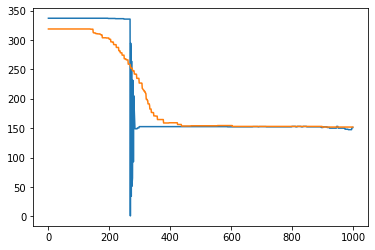

In [3]:
import matplotlib.pyplot as plt
t0 = zeros(shape=n)
for i in range(0,n):
    t0[i] = days[argmax(gmin_Iso[:,i])]
plt.plot(t0)

t1 = zeros(shape=n)
for i in range(0,n):
    t1[i] = days[argmax(gmin_Iso_gf[:,i])]
plt.plot(t1)


In [4]:
t0[0]-t1[0]

18.25